### Import dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

### Load model

In [3]:
MODEL_NAME = "KarlsonAV/bert-base-uncased-tripadvisor"

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Load dataset

In [3]:
TEST_DATASET_PATH = os.path.join("data", "test.csv")

test_dataset = load_dataset('csv', data_files=TEST_DATASET_PATH)['train']

### Evaluate model

In [4]:
def classify_review(review):
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    return np.argmax(probs.detach().numpy()) + 1

In [5]:
results = []

progress_bar = tqdm(total=len(test_dataset['text']))
for i, review in enumerate(test_dataset['text']):
    time_start = time.time()
    rating_predicted = classify_review(review)
    time_end = time.time()
    
    results.append({
        "review": review,
        "rating": test_dataset['label'][i],
        "rating_predicted": rating_predicted,
        "time": time_end - time_start
    })
    
    progress_bar.update(1)
    
df_eval = pd.DataFrame(results)


100%|█████████▉| 3073/3074 [04:03<00:00, 12.09it/s]

### Eval results

In [28]:
def plot_confusion_matrix(cm_df):
    sorted_index = sorted(cm_df.index, key=lambda x: str(x))
    sorted_columns = sorted(cm_df.columns, key=lambda x: str(x))
    cm_df = cm_df.loc[sorted_index, sorted_columns]

    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(cm_df, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    # Setting tick marks and labels
    ax.set(xticks=np.arange(cm_df.shape[1]),
           yticks=np.arange(cm_df.shape[0]),
           xticklabels=sorted_columns, yticklabels=sorted_index,
           title='Confusion Matrix',
           ylabel='Actual labels',
           xlabel='Predicted labels')

    # Rotate the tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'  # Use 'd' for integers, 'g' for more general formats
    thresh = cm_df.values.max() / 2.  # Threshold for text color contrast
    for i in range(cm_df.shape[0]):
        for j in range(cm_df.shape[1]):
            ax.text(j, i, format(cm_df.iat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_df.iat[i, j] > thresh else "black")
    
    fig.tight_layout()
    plt.show()

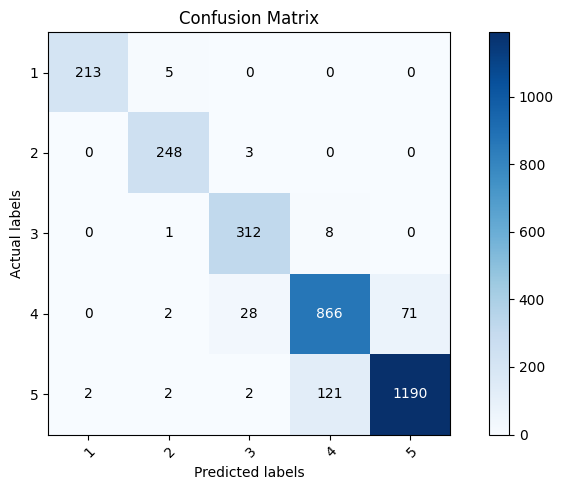

Accuracy: 0.9202992843201041
Recall: 0.9472393240097665
Precision: 0.934066609831001
F1 Score: 0.9402398674507062
Average time per review: 0.07851578728595801


In [30]:
def compute_metrics(df, true_col, pred_col):
    # Calculate confusion matrix
    labels = df[true_col].unique()
    cm = confusion_matrix(df[true_col], df[pred_col], labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(df[true_col], df[pred_col])
    recall = recall_score(df[true_col], df[pred_col], average='macro')
    precision = precision_score(df[true_col], df[pred_col], average='macro')
    f1 = f1_score(df[true_col], df[pred_col], average='macro')
    
    avg_time = df['time'].mean()
    
    return cm_df, accuracy, recall, precision, f1, avg_time

cm_df, accuracy, recall, precision, f1, avg_time = compute_metrics(df_eval, 'rating', 'rating_predicted')
plot_confusion_matrix(cm_df)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Average time per review:", avg_time)